Import Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

Linear Regression Class

In [2]:
class LinReg(object):
    def __init__(self):
        self.t0=200
        self.t1=100000
    
    def predict(self,X:np.ndarray)->np.ndarray:
        return X@self.w
    
    def loss(self,X:np.ndarray,y:np.ndarray)->float:
        error=y-self.predict(X)
        return 0.5*np.transpose(error)@error
    
    def rmse(self,X:np.ndarray,y:np.ndarray)->float:
        return np.sqrt((2/X.shape[0])*self.loss(X,y))
    
    def fit(self,X:np.ndarray,y:np.ndarray)->np.ndarray:
        self.w=np.linalg.pinv(X)@y
        return self.w

    def calculate_gradient(self,X:np.ndarray,y:np.ndarray)->np.ndarray:
        return np.transpose(X)@(self.predict(X)-y)

    def update_weights(self,grad:np.ndarray,lr:float)->np.ndarray:
        return (self.w-lr*grad)
    
    def learning_schedule(self,t):
        return self.t0/(self.t1+t)
    
    def gradient_descent(self,X:np.ndarray,y:np.ndarray,num_epochs:int,lr:float)->np.ndarray:
        self.w=np.zeros((X.shape[1]))
        self.w_all=[]
        self.err_all=[]
        for i in range(num_epochs):
            dJdW=self.calculate_gradient(X,y)
            self.w_all.append(self.w)
            self.err_all.append(self.loss(X,y))
            self.w=self.update_weights(dJdW,lr)
        return self.w
    
    def mini_batch_gradient_descent(self,X:np.ndarray,y:np.ndarray,num_epochs:int,batch_size:int)->np.ndarray:
        self.w=np.zeros((X.shape[1]))
        self.w_all=[]
        self.err_all=[]
        mini_batch_id=0

        for epoch in range(num_epochs):
            shuffled_indices=np.random.permutation(X.shape[0])
            X_shuffled=X[shuffled_indices]
            y_shuffled=y[shuffled_indices]
            for i in range(0,X.shape[0],batch_size):
                mini_batch_id+=1
                xi=X_shuffled[i:i+batch_size]
                yi=y_shuffled[i:i+batch_size]
                
                self.w_all.append(self.w)
                self.err_all.append(self.loss(xi,yi))

                dJdW=(2/batch_size)*self.calculate_gradient(xi,yi)
                self.w=self.update_weights(dJdW,self.learning_schedule(mini_batch_id))
        return self.w

    def stochastic_gradient_descent(self,X:np.ndarray,y:np.ndarray,num_epochs:int)->np.ndarray:
        self.w=np.zeros((X.shape[1]))
        self.w_all=[]
        self.err_all=[]

        for epoch in range(num_epochs):
            for i in range(X.shape[0]):
                random_index=np.random.randint(X.shape[0])
                xi=X[random_index:random_index+1]
                yi=y[random_index:random_index+1]

                self.w_all.append(self.w)
                self.err_all.append(self.loss(xi,yi))

                gradients=2*self.calculate_gradient(xi,yi)
                lr=self.learning_schedule(epoch*X.shape[0]+i)
                self.w=self.update_weights(gradients,lr)
        return self.w

Functions that performs Polynomial Transformation

In [3]:
import itertools
import functools

def get_combinations(x,degree):
    return itertools.combinations_with_replacement(x,degree)

def compute_new_feature(items):
    return functools.reduce(lambda x,y:x*y,items)

In [4]:
{items:compute_new_feature(items) for items in get_combinations([2],3)}

{(2, 2, 2): 8}

In [5]:
{items:compute_new_feature(items) for items in get_combinations([2,3],3)}

{(2, 2, 2): 8, (2, 2, 3): 12, (2, 3, 3): 18, (3, 3, 3): 27}

In [6]:
{items:compute_new_feature(items) for items in get_combinations([3,4],4)}

{(3, 3, 3, 3): 81,
 (3, 3, 3, 4): 108,
 (3, 3, 4, 4): 144,
 (3, 4, 4, 4): 192,
 (4, 4, 4, 4): 256}

In [7]:
def polynomial_transform(x,degree,logging=False):
    if x.ndim==1:
        x=x[:,None]
    x_t=x.transpose()
    features=[np.ones(len(x))]
    if logging:
        print("Input : ",x)
    for degree in range(1,degree+1):
        for items in get_combinations(x_t,degree):
            features.append(compute_new_feature(items))
            if logging:
                print(items," : ",compute_new_feature(items))
    if logging:
        print(np.asarray(features).transpose())
    return np.asarray(features).transpose()

In [8]:
polynomial_transform(np.array([[2,3],[4,5]]),degree=2,logging=True)

Input :  [[2 3]
 [4 5]]
(array([2, 4]),)  :  [2 4]
(array([3, 5]),)  :  [3 5]
(array([2, 4]), array([2, 4]))  :  [ 4 16]
(array([2, 4]), array([3, 5]))  :  [ 6 20]
(array([3, 5]), array([3, 5]))  :  [ 9 25]
[[ 1.  2.  3.  4.  6.  9.]
 [ 1.  4.  5. 16. 20. 25.]]


array([[ 1.,  2.,  3.,  4.,  6.,  9.],
       [ 1.,  4.,  5., 16., 20., 25.]])

Non-Linear Training Data Generation - y=sin(2πx1)+noise

In [9]:
def create_nonlin_training_set(func,sample_size,std):
    x=np.linspace(0,1,sample_size)
    y=func(x)+np.random.normal(scale=std,size=x.shape)
    return x,y
def nonlin(x):
    return np.sin(2*np.pi*x)

In [10]:
def visualize_training_data(X_train,y_train):
    points=np.linspace(0,1,100)
    output=nonlin(points)
    sns.set(style='whitegrid')
    sns.scatterplot(X_train,y_train),sns.lineplot(points,output)
def visualize_model_fit(X,y,lin_reg,degree):
    points=np.linspace(0,1,100)
    output=nonlin(points)
    sns.set(style='whitegrid')
    sns.scatterplot(X,y),sns.lineplot(points,output)
    y_hat=lin_reg.predict(polynomial_transform(points,degree))
    sns.lineplot(points,y_hat,palette=['r'])

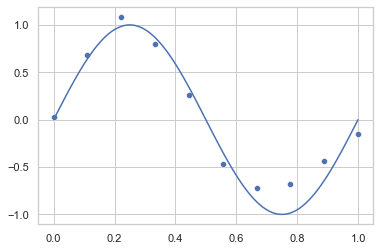

In [11]:
num_samples=10
points=np.linspace(0,1,100)
X,y=create_nonlin_training_set(nonlin,num_samples,0.2)
visualize_training_data(X,y)


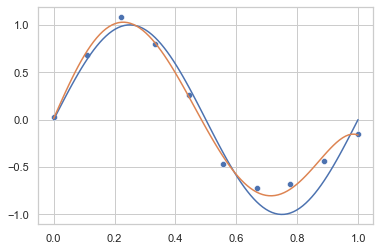

In [12]:
degree=5
X_transform=polynomial_transform(X,degree)
lin_reg=LinReg()
lin_reg.fit(X_transform,y)
visualize_model_fit(X,y,lin_reg,degree)

In [13]:
lin_reg.w

array([ 1.29175546e-02,  7.25515908e+00,  7.77929225e-01, -8.62389674e+01,
        1.41502521e+02, -6.34714565e+01])

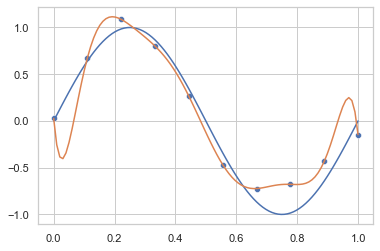

In [14]:
degree=9
X_transform=polynomial_transform(X,degree)
lin_reg=LinReg()
lin_reg.fit(X_transform,y)
visualize_model_fit(X,y,lin_reg,degree)

In [15]:
lin_reg.w

array([ 2.67113302e-02, -3.69551607e+01,  9.80347070e+02, -8.66063595e+03,
        3.96509513e+04, -1.06256435e+05,  1.72101266e+05, -1.65472517e+05,
        8.68391688e+04, -1.91453636e+04])

Ridge Regularization - L2 Regularization
Change are made in the following functions in the LinReg Class 
1. loss() 
2. calculate_gradient() 
3. fit() 


In [16]:
class LinReg(object):
    def __init__(self):
        self.t0=200
        self.t1=100000
    
    def predict(self,X:np.ndarray)->np.ndarray:
        return X@self.w
    
    def loss(self,X:np.ndarray,y:np.ndarray,reg_rate:float)->float:
        error=y-self.predict(X)
        return 0.5*np.transpose(error)@error+(reg_rate/2)*(np.transpose(self.w)@self.w)
    
    def rmse(self,X:np.ndarray,y:np.ndarray)->float:
        return np.sqrt((2/X.shape[0])*self.loss(X,y))
    
    def fit(self,X:np.ndarray,y:np.ndarray,reg_rate:float)->np.ndarray:
        self.w=np.zeros((X.shape[1]))
        eye=np.eye(np.size(X,1))
        self.w=np.linalg.solve( reg_rate*eye + X.T@X , X.T@y)
        return self.w

    def calculate_gradient(self,X:np.ndarray,y:np.ndarray,reg_rate:float)->np.ndarray:
        return np.transpose(X)@(self.predict(X)-y) + reg_rate*self.w

    def update_weights(self,grad:np.ndarray,lr:float)->np.ndarray:
        return (self.w-lr*grad)
    
    def learning_schedule(self,t):
        return self.t0/(self.t1+t)
    
    def gradient_descent(self,X:np.ndarray,y:np.ndarray,num_epochs:int,lr:float)->np.ndarray:
        self.w=np.zeros((X.shape[1]))
        self.w_all=[]
        self.err_all=[]
        for i in range(num_epochs):
            dJdW=self.calculate_gradient(X,y)
            self.w_all.append(self.w)
            self.err_all.append(self.loss(X,y))
            self.w=self.update_weights(dJdW,lr)
        return self.w
    
    def mini_batch_gradient_descent(self,X:np.ndarray,y:np.ndarray,num_epochs:int,batch_size:int)->np.ndarray:
        self.w=np.zeros((X.shape[1]))
        self.w_all=[]
        self.err_all=[]
        mini_batch_id=0

        for epoch in range(num_epochs):
            shuffled_indices=np.random.permutation(X.shape[0])
            X_shuffled=X[shuffled_indices]
            y_shuffled=y[shuffled_indices]
            for i in range(0,X.shape[0],batch_size):
                mini_batch_id+=1
                xi=X_shuffled[i:i+batch_size]
                yi=y_shuffled[i:i+batch_size]
                
                self.w_all.append(self.w)
                self.err_all.append(self.loss(xi,yi))

                dJdW=(2/batch_size)*self.calculate_gradient(xi,yi)
                self.w=self.update_weights(dJdW,self.learning_schedule(mini_batch_id))
        return self.w

    def stochastic_gradient_descent(self,X:np.ndarray,y:np.ndarray,num_epochs:int)->np.ndarray:
        self.w=np.zeros((X.shape[1]))
        self.w_all=[]
        self.err_all=[]

        for epoch in range(num_epochs):
            for i in range(X.shape[0]):
                random_index=np.random.randint(X.shape[0])
                xi=X[random_index:random_index+1]
                yi=y[random_index:random_index+1]

                self.w_all.append(self.w)
                self.err_all.append(self.loss(xi,yi))

                gradients=2*self.calculate_gradient(xi,yi)
                lr=self.learning_schedule(epoch*X.shape[0]+i)
                self.w=self.update_weights(gradients,lr)
        return self.w

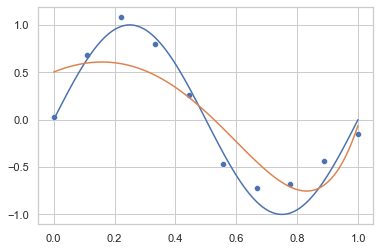

In [17]:
degree=9
X_transform=polynomial_transform(X,degree)
lin_reg=LinReg()
lin_reg.fit(X_transform,y,0.01)
visualize_model_fit(X,y,lin_reg,degree)

Lasso Regularization - L1 Regularization

In [18]:
from sklearn.linear_model import Lasso
import pandas as pd
reg_rate=0.01
lasso=Lasso(alpha=reg_rate)
lasso.fit(X_transform,y)


Lasso(alpha=0.01)

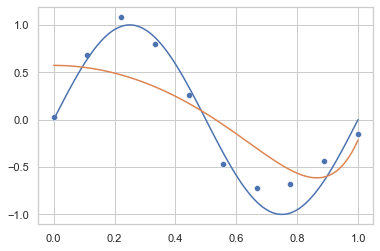

In [19]:
visualize_model_fit(X,y,lasso,degree)

In [20]:

pd.DataFrame({'Rigde':lin_reg.w,'Lasso':lasso.coef_})

,Rigde,Lasso
0,0.502335,0.000000
1,1.292561,-0.000000
2,-3.663913,-2.039875
3,-1.778696,-0.000000
4,0.131239,0.000000
5,1.095999,0.000000
6,1.281568,0.000000
7,0.976445,0.000000
8,0.401701,0.000000
9,-0.299360,1.252267


# Multi-Output/Multi-Label Regresssion

In [21]:
from sklearn.datasets import make_regression
X,y,coef=make_regression(100,10,10,bias=1,n_targets=5,shuffle=True,coef=True)
X.shape,y.shape

((100, 10), (100, 5))

In [22]:
from sklearn.model_selection import train_test_split
def add_dummy(x): return np.column_stack((np.ones(x.shape[0]),x))
def preprocess(X,y):
  X_dummy = add_dummy(X)
  return  train_test_split(X_dummy,y,test_size = 0.2, random_state = 42)

In [23]:
X_train, X_test, y_train, y_test = preprocess(X,y)

We modify LinReg class by changing Weight Vector to Weight Matrix

In [46]:
class LinReg(object):
    def __init__(self):
        self.t0=200
        self.t1=100000
    
    def predict(self,X:np.ndarray)->np.ndarray:
        return X@self.w
    
    def loss(self,X:np.ndarray,y:np.ndarray,reg_rate:float)->float:
        error=y-self.predict(X)
        return 0.5*np.transpose(error)@error+(reg_rate/2)*(np.transpose(self.w)@self.w)
    
    def rmse(self,X:np.ndarray,y:np.ndarray)->float:
        return np.sqrt((2/X.shape[0])*self.loss(X,y))
    
    def fit(self,X:np.ndarray,y:np.ndarray,reg_rate:float)->np.ndarray:
        self.w=np.zeros((X.shape[1],y.shape[1]))
        eye=np.eye(np.size(X,1))
        self.w=np.linalg.solve( reg_rate*eye + X.T@X , X.T@y)
        return self.w

    def calculate_gradient(self,X:np.ndarray,y:np.ndarray,reg_rate:float)->np.ndarray:
        return np.transpose(X)@(self.predict(X)-y) + reg_rate*self.w

    def update_weights(self,grad:np.ndarray,lr:float)->np.ndarray:
        return (self.w-lr*grad)
    
    def learning_schedule(self,t):
        return self.t0/(self.t1+t)
    
    def gradient_descent(self,X:np.ndarray,y:np.ndarray,num_epochs:int,lr:float,reg_rate:float)->np.ndarray:
        self.w=np.zeros((X.shape[1],y.shape[1]))
        self.w_all=[]
        self.err_all=[]
        for i in range(num_epochs):
            dJdW=self.calculate_gradient(X,y,reg_rate)
            self.w_all.append(self.w)
            self.err_all.append(self.loss(X,y,reg_rate))
            self.w=self.update_weights(dJdW,lr)
        return self.w
    
    def mini_batch_gradient_descent(self,X:np.ndarray,y:np.ndarray,num_epochs:int,batch_size:int)->np.ndarray:
        self.w=np.zeros((X.shape[1]))
        self.w_all=[]
        self.err_all=[]
        mini_batch_id=0

        for epoch in range(num_epochs):
            shuffled_indices=np.random.permutation(X.shape[0])
            X_shuffled=X[shuffled_indices]
            y_shuffled=y[shuffled_indices]
            for i in range(0,X.shape[0],batch_size):
                mini_batch_id+=1
                xi=X_shuffled[i:i+batch_size]
                yi=y_shuffled[i:i+batch_size]
                
                self.w_all.append(self.w)
                self.err_all.append(self.loss(xi,yi))

                dJdW=(2/batch_size)*self.calculate_gradient(xi,yi)
                self.w=self.update_weights(dJdW,self.learning_schedule(mini_batch_id))
        return self.w

    def stochastic_gradient_descent(self,X:np.ndarray,y:np.ndarray,num_epochs:int)->np.ndarray:
        self.w=np.zeros((X.shape[1]))
        self.w_all=[]
        self.err_all=[]

        for epoch in range(num_epochs):
            for i in range(X.shape[0]):
                random_index=np.random.randint(X.shape[0])
                xi=X[random_index:random_index+1]
                yi=y[random_index:random_index+1]

                self.w_all.append(self.w)
                self.err_all.append(self.loss(xi,yi))

                gradients=2*self.calculate_gradient(xi,yi)
                lr=self.learning_schedule(epoch*X.shape[0]+i)
                self.w=self.update_weights(gradients,lr)
        return self.w

In [47]:
lin_reg=LinReg()
w=lin_reg.fit(X_train,y_train,0)
np.testing.assert_almost_equal(w[1:,:],coef,decimal=2)

In [48]:
w=lin_reg.gradient_descent(X_train,y_train,100,0.01,reg_rate=0)
np.testing.assert_almost_equal(w[1:,:],coef,decimal=2)